### Imports

In [3]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from ypstruct import structure
import timeit
import ast



### Defining the functions used to run the Evolutionary Algorithm

#### Function to create/format the distance matrices

In [5]:
def dist_mat(city_csv: str, nb_cities: int) -> list[list]:

    """
    Read a CSV file containing information about distances between cities and generate a distance matrix.

    Args:
    city_csv (str): The file path to the CSV file containing city-to-city distance data.
    nb_cities (int): The number of cities for which the distance matrix needs to be generated.

    Returns:
    list[list]: A 2D list representing the distance matrix where each element at position [i, j] contains the distance
    from city i to city j.

    The function reads the provided CSV file using pandas and expects the file to have the following structure:
    - Columns: "edge", "cost" where the first (len(nb_cities) - 1) rows correspond to the cost of going from city with ID 0 to city with ID edge. 
    The second set of (len(nb_cities) - 1) rows correspond to the cost of going from city with ID 1 to city with ID edge, and so on.

    It constructs a distance matrix where the (i, j) element contains the distance from city i to city j.
    The diagonal elements (i, i) are set to 0 since the distance from a city to itself is always 0.
    The function assumes that city indices are zero-based (0 to nb_cities-1).
    """

    # read in the CSV file using pandas
    city = pd.read_csv(city_csv, sep = ";")

    # create a vertex_id column which identifies which city the distance to another city is being measured from
    city_vertex_id = []
    for i in range(0, nb_cities, 1):
        for _ in range(0, nb_cities-1, 1):
            city_vertex_id.append(i)
    city["vertex_id"] = city_vertex_id

    # create the distance matrix 
    city_dist_mat = []
    for i in range(0, nb_cities, 1):
        city_vertex = city[city["vertex_id"] == i]
        costs = city_vertex["cost"].values.tolist()
        # insert 0 in the row of the city at the index corresponding to that city. 
        costs.insert(i, 0)
        city_dist_mat.append(costs)
        
    return city_dist_mat
    

In [6]:
# create both distance matrices
burma_dist_mat = dist_mat("Data/burma14.xml.csv", nb_cities=14)
braz_dist_mat = dist_mat("Data/brazil58.xml.csv", nb_cities=58)

In [7]:
# create lists of the city IDs
brazil_city_ids = list(range(0, len(braz_dist_mat), 1))
burma_city_ids = list(range(0, len(burma_dist_mat), 1))

Example of candidate solution structure
```python 
candidate_solution = structure()
candidate_solution.chromosome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0]
candidate_solution.fitness = cost(candidate_solution.chromosome, distance_matrix)
```


In [8]:
def generate_initial_pop(city_ids: list[int], p: int) -> list[structure]:
    
    """
    Generate the initial population of candidate solutions for an evolutionary algorithm Travelling Salesman Problem (TSP).

    Args:
    city_ids (list[int]): A list of city identifiers or indices used for creating candidate solutions.
    p (int): The population size, i.e., the number of candidate solutions to generate.

    Returns:
    list[structure]: A list of candidate solutions, each candidate solution is represented as a "structure" object from the ypstruct library.

    This function generates an initial population of candidate solutions for an evolutionary algorithm.
    Each candidate solution is represented as a "structure" object from the ypstruct library, where the "chromosome" attribute contains
    a random permutation of city_ids, and the "fitness" attribute is initially set to "None".

    The function randomly samples city_ids without replacement to create the chromosome for each candidate solution and ensure that
    no city appears twice within the chromosome.
    The population size is determined by the "p" parameter.

    Example:
    If city_ids = [0, 1, 2, 3, 4] and p = 3, the function may produce candidate solutions like the following:
    [
        structure(chromosome=[3, 0, 2, 1, 4], fitness=None),
        structure(chromosome=[1, 0, 4, 2, 3], fitness=None),
        structure(chromosome=[2, 0, 3, 1, 4], fitness=None)
    ]
    """

    # empty list to which will be appended the candidate solutions
    init_pop = []
    # generate the candidate solutions
    for _ in range(p):
        candidate_sol = structure()
        # sample without replacement from city_ids to ensure that no city appears twice in the chromosome of a candidate solution
        candidate_sol.chromosome = random.sample(city_ids, k = len(city_ids))
        candidate_sol.fitness = None
        init_pop.append(candidate_sol)
    
    # return the initial population of candidate solutions
    return init_pop

In [9]:
def cost(candidate_solution: structure, distance_matrix: list[list]) -> float:

    """
    Calculate the cost of a candidate solution for the Travelling Salesman Problem (TSP).

    Args:
    candidate_solution (structure): A candidate solution represented as a "structure" object from the ypstruct library with a 
    "chromosome" attribute and a "fitness" attribute.
    distance_matrix (list[list]): A 2D list representing the distance matrix where each element at position [i, j] contains the distance
    from city i to city j.

    Returns:
    float: The total cost of the candidate solution, which represents the length of the TSP tour.

    The function calculates the cost of a TSP solution by summing up the distances between consecutive cities in the
    candidate solution's chromosome. It also includes the cost of returning to the starting city.
    """

    # cost of going from last city in the chromosme back to the starting chromosome
    return_to_start_cost = distance_matrix[len(distance_matrix)-1][candidate_solution.chromosome[0]]
    # calculate the cost for the rest of the tour
    travel_cost = 0
    for i in range(0, len(distance_matrix)-1, 1):
        travel_cost += distance_matrix[candidate_solution.chromosome[i]][candidate_solution.chromosome[i+1]]

    return travel_cost + return_to_start_cost


In [10]:
def eval_pop_fitness(pop: list[structure], distance_matrix: list[list]) -> None:
    
    """
    Evaluate the fitness of a population of candidate solutions to a Travelling Salesman Problem (TSP) based on a given distance matrix.

    Args:
    pop (list[structure]): A list of candidate solutions, where each candidate is represented as a "structure" object from the ypstruct library
    and has a "chromsome" attribute and a "fitness" attribute.
    distance_matrix (list[list]): A 2D list representing the distance matrix where each element at position [i, j] contains the distance
    from city i to city j.

    Returns:
    None

    This function evaluates the fitness of each candidate solution in the population by calculating the total tour length
    of each candidate. The "cost" function is used to calculate the tour length of a candidate solution based on the
    given distance matrix. The fitness value is then assigned to the "fitness" attribute of each candidate.

    """
    
    for candidate in pop:
        candidate.fitness = cost(candidate, distance_matrix)

    return None

In [11]:
def tournament_selection(pop: list[structure], tournament_size: int) -> structure:
    
    
    """
    Performs tournament selection to choose an individual from a population of candidate solutions based on their fitness.

    Args:
    pop (list[structure]): A list of candidate solutions, where each candidate is represented as a "structure" object from the ypstruct library
    and has a "chromosome" attribute and a "fitness" attribute.
    tournament_size (int): The number of candidates to participate in the tournament.

    Returns:
    structure: The selected candidate with the best fitness.

    This function performs tournament selection, to select an individual from a population. 
    The selection process involves the following steps:

    1. Randomly select "tournament_size" candidates from the population without replacement.
    2. Sort the tournament candidates in ascending order of their fitness values.
    3. Retrieve the object(s) with the lowest fitness value (best performers).
    4. In the case of ties for first place, randomly select one candidate from the best-performing candidates.

    The selected candidate with the best fitness is returned as the result.
    """

    # randomly select tournament_size candidates from the population without replacement
    tournament_candidates  = random.sample(pop, k = tournament_size)

    # sort the tournament candidates from lowest to highest cost
    sorted_list = sorted(tournament_candidates, key=lambda obj: obj.fitness, reverse = False)

    # retrieve the object(s) with the lowest cost value
    min_fitness = sorted_list[0].fitness
    top_objects = [obj for obj in sorted_list if obj.fitness == min_fitness]

    # handle ties for first place by randomly selecting a tournament candidate from the best performing candidates
    chosen_best_solution = random.choice(top_objects)

    return chosen_best_solution

In [12]:
def crossover(parent1: structure, parent2: structure, crossover_type: str = "ordered"):
    
    """
    Performs the crossover operation on two parent chromosomes to generate two children for the Travelling Salesman Problem (TSP).

    Args:
    parent1 (structure): A parent chromosome representing a TSP candidate solution, represented as a "structure" object from the ypstruct library
    and has a "chromsome" attribute and a "fitness" attribute.
    parent2 (structure): Another parent chromosome representing a TSP candidate solution, represented as a "structure" object from the 
    ypstruct library and has a "chromsome" attribute and a "fitness".
    crossover_type (str): The type of crossover to apply. Can be "ordered" or "fix" (default is "ordered").

    Returns:
    c: A child chromosome resulting from the crossover operation.
    d: Another child chromosome resulting from the crossover operation.

    The function allows to choose from two types of crossover operations:

    - "ordered" (default): Applies a standard ordered crossover by selecting a random crossover point and copying segments
      from the parents to create two children. Ensures that children do not contain duplicate cities beyond the crossover
      point.

    - "fix": Applies a single-point crossover with a fix. Ensures that children do not contain duplicate cities beyond the
      crossover point and maintains the order of certain cities.

    The function returns two child solutions, c and d, each represented as a "structure" object from the ypstruct library
    and have a "chromosome" attribute and a "fitness" attribute.
    """

    city_ids = sorted(set(parent1.chromosome))

    # perform crossover with fix
    if crossover_type == "fix":

        # randomly choose crossover point
        crossover_point = np.random.randint(1, len(city_ids)-1)

        child1 = [None] * len(parent1.chromosome)
        child2 = [None] * len(parent2.chromosome)

        # copy segment from first parent
        child1[:crossover_point] = parent1.chromosome[:crossover_point]
        child2[:crossover_point] = parent2.chromosome[:crossover_point]

        # look at corresponding segment in parent 2 and find which elements have not been copied yet:
        not_been_copied_yet1 = list(set(parent2.chromosome[:crossover_point]) - set(child1[:crossover_point]))
        not_been_copied_yet2 = list(set(parent1.chromosome[:crossover_point]) - set(child2[:crossover_point]))
        
        mapping1 = {} # {i: j} where the i are the values in the corresponding segment of parent 2 which have not been copied yet and
                     # the j are the values at the location of i in parent 1
        mapping2 = {}

        # mapping for 1st child
        for i in range(crossover_point):
             if parent2.chromosome[i] in not_been_copied_yet1:
                mapping1[parent2.chromosome[i]] = child1[i]

        # mapping for 2nd child
        for i in range(crossover_point):
             if parent1.chromosome[i] in not_been_copied_yet2:
                mapping2[parent1.chromosome[i]] = child2[i]

        
        # first child
        is_space_for_insert1 = False
        # find where the Js are in parent 2 and place the corresponding I there in the child:
        for key in mapping1.keys():
             # check if index is taken:
            i = key
            j = mapping1[key] 
            if child1[parent2.chromosome.index(j)] == None:
                child1[parent2.chromosome.index(j)] = i
            else:

                current_index = parent2.chromosome.index(j)
                while not is_space_for_insert1:
                    if child1[current_index] != None:
                        current_value = child1[current_index]
                        current_index = parent2.chromosome.index(current_value)
                    else:
                        is_space_for_insert1 = True
                        child1[current_index] = i
            is_space_for_insert1 = False

        for i in range(len(parent2.chromosome)):
            if child1[i] == None:
                child1[i] = parent2.chromosome[i]

        # second child
        is_space_for_insert2 = False
        # find where the Js are in parent 1 and place the corresponding I there in the child:
        for key in mapping2.keys():
             # check if index is taken:
            i = key
            j = mapping2[key] 
            if child1[parent1.chromosome.index(j)] == None:
                child1[parent1.chromosome.index(j)] = i
            else:

                current_index = parent1.chromosome.index(j)
                while not is_space_for_insert2:
                    if child2[current_index] != None:
                        current_value = child2[current_index]
                        current_index = parent1.chromosome.index(current_value)
                    else:
                        is_space_for_insert2 = True
                        child2[current_index] = i
            is_space_for_insert2 = False

        for i in range(len(parent1.chromosome)):
            if child2[i] == None:
                child2[i] = parent1.chromosome[i]

        c = structure()
        d = structure()

        c.chromosome = child1
        d.chromosome = child2

        return c, d    

    # perform ordered crossover
    else:

        # randomly choose crossover point
        crossover_point = np.random.randint(1, len(city_ids)-1)

        # initialize two empty offspring
        child1 = [None] * len(parent1.chromosome)
        child2 = [None] * len(parent2.chromosome)

        # copy the first part of parents to offspring without duplicates
        for i in range(crossover_point):
                child1[i] = parent1.chromosome[i]
                child2[i] = parent2.chromosome[i]

        # fill in the remaining part of the offsprings from the other parent without duplicates
        remaining_nodes1 = [node for node in parent2.chromosome if node not in child1]
        remaining_nodes2 = [node for node in parent1.chromosome if node not in child2]

        child1[crossover_point:] = remaining_nodes1
        child2[crossover_point:] = remaining_nodes2

        # the children solutions
        c = structure()
        d = structure()
        c.chromosome = child1
        d.chromosome = child2

        return c, d

In [13]:
def mutation(offspring: structure, nb_mutations:int = 1) -> structure:
     
     """
     Performs a mutation operation on an offspring's chromosome.

     Args:
     offspring (structure): The offspring structure containing a chromosome to be mutated, represented as a "structure" object from the ypstruct 
     library and has a "chromosome" attribute and a "fitness" attribute.
     nb_mutations (int, optional): The number of mutation operations to be applied. If nb_mutations is -1, an inversion
     mutation is performed. If nb_mutations is greater than or equal to 1, that many swap mutations are performed. Default is 1 (1 swap
     mutation).

     Returns:
     structure: The offspring structure after the mutation operation.

     The function performs either an inversion mutation or multiple swap mutations on the given offspring's chromosome.

     - Inversion Mutation (nb_mutations = -1):
     An inversion mutation selects two random positions within the chromosome and inverts the segment between them.

     - Swap Mutation (nb_mutations >= 1):
     The function performs the required number of swap mutations. Each swap mutation selects two random positions
     in the chromosome and swaps the cities at those positions.
    """

     # perform an inversion mutation
     if nb_mutations == -1:

          # select two random positions, the cities between both positions will be inverted
          pos1, pos2 = random.sample(range(len(offspring.chromosome)), 2)
          start, end = min(pos1, pos2), max(pos1, pos2)

          # reverse the segment between the selected positions
          offspring.chromosome[start:end + 1] = offspring.chromosome[start:end + 1][::-1]

          return offspring
     else:
          # perform required number of swap mutations
          for _ in range(0, nb_mutations):
               idx = range(len(offspring.chromosome))
               # randomly select what two positions will be swapped in the chromosome
               i1, i2 = random.sample(idx, 2)
               offspring.chromosome[i1], offspring.chromosome[i2] = offspring.chromosome[i2], offspring.chromosome[i1]
          return offspring


In [14]:
def replacement(pop: list[structure], child1: structure, child2: structure, replacement_type: str = "worse") -> list[structure]:

    """
    Replace solutions in the population with the generated children based on a specified replacement strategy.

    Args:
    pop (list[structure]): The current population of solutions where each solution is represented as a "structure" object from the ypstruct library
    and have a "chromosome" attribute and a "fitness" attribute.
    child1 (structure): The first child generated through a crossover operation, represented as a "structure" object from the ypstruct library
    and has a "chromsome" attribute and a "fitness" attribute.
    child2 (structure): The second child generated through a crossover operation, represented as a "structure" object from the ypstruct library
    and has a "chromosome" attribute and a "fitness" attribute.
    replacement_type (str, optional): The strategy for replacement. Options are "first worse" and "worse"
        "first worse" replaces the first two worse solutions with the children.
        "worse" replaces the worst solution(s) with the children. Defaults to "worse"

    Returns:
    list[structure]: The updated population with replaced solutions based on the chosen replacement strategy.

    The function replaces solutions in the population with the generated children while considering the specified replacement
    strategy. It handles ties in fitness values.
    """

    # perform first worse replacement
    if replacement_type == "first worse": 
        children = [child1, child2]
        # sort the children in ascending order based on fitness value
        sorted_children = sorted(children, key=lambda obj: obj.fitness)
        counter = 0
        # loop over the population
        for i in range(len(pop)):
            # check if first child in the children list has better or equal fitness to the current candidate solution being looped over
            if sorted_children[0].fitness <= pop[i].fitness:
                # if it is, insert it into the population in the place of the solution it is better than or equal to
                pop[pop.index(pop[i])] = sorted_children[0]
                # remove it from the children list
                sorted_children.pop(0)
                counter += 1
            # if counter is 2 that means we have repeated the above operation twice and that both children have replaced one of the 
            # candidate solutions
            if counter == 2:
                break

    # perform worse replacement (replace two worse solutions with the children (if the children are better))
    elif replacement_type == "worse":
        # sort the solutions in the previous population
        sorted_list = sorted(pop, key=lambda obj: obj.fitness, reverse=True)
        # retrieve the object(s) with the highest fitness value
        max_fitness = sorted(list(set([obj.fitness for obj in sorted_list])))[-1]
        top_objects = [obj for obj in sorted_list if obj.fitness == max_fitness]

        # handles the case where two or more solutions may have equal worse fitness. Randomly selects two of them.
        if len(top_objects) != 1:
            chosen_worse_solution1, chosen_worse_solution2 = random.sample(top_objects, 2)
            # only replace with children if the children have better fitness than the worse fitness
            if child1.fitness <= max_fitness:
                pop[pop.index(chosen_worse_solution1)] = child1
            if child2.fitness <= max_fitness:
                pop[pop.index(chosen_worse_solution2)] = child2
            return pop

        # only happens if len(top_objetcs) == 1
        chosen_worse_solution = top_objects[0]

        # retrieve the object(s) with the second-to-last highest fitness value
        second_to_last_fitness = sorted(list(set([obj.fitness for obj in sorted_list])))[-2]
        second_to_last_solutions = [obj for obj in sorted_list if obj.fitness == second_to_last_fitness]

        # Handle ties for second-to-last place by randomly selecting one
        chosen_second_to_worse_solution = random.choice(second_to_last_solutions)

        # replace the worse solutions in the population with the children
        # only replace if children are better
        children = [child2, child1]
        sorted_children = sorted(children, key=lambda obj: obj.fitness)
        best_child = sorted_children[0]
        worse_child = sorted_children[1]

        # Logic here: if the best child is better than the second to worse solution in the population, replace that solution with the child
        # then check if the second best child is better than the worse solution in the population and if it replace that solution with the 
        # child. If the best child is not better than the second to worse solution, check if it's better than the worse solution and replace
        # the worse solution with the best child. Logically, the second best child will not be better than any of the 2 worse solutions so 
        # do not introduce it to the population.

        if best_child.fitness <= chosen_second_to_worse_solution.fitness:
            pop[pop.index(chosen_second_to_worse_solution)] = best_child
            if worse_child.fitness <= chosen_worse_solution.fitness:
                pop[pop.index(chosen_worse_solution)] = worse_child
            return pop
        if best_child.fitness <= chosen_worse_solution.fitness:
            pop[pop.index(chosen_worse_solution)] = best_child
            return pop
        
    return pop

In [15]:
def TSP(dist_mat: list[list], city_ids: list[int], p: int, tournament_size: int, nb_mutations: int = 1, replacement_type: str = "worse", crossover_type:str = "ordered", maxit: int = 10000, output_file: str = None) -> None:
    
    """
    Solves the Travelling Salesman Problem (TSP) using an evolutionary algorithm.

    Args:
    dist_mat (list[list]): A 2D distance matrix where dist_mat[i][j] represents the distance from city i to city j.
    city_ids (list[int]): A list of unique identifiers for each city.
    p (int): The population size.
    tournament_size (int): The size of the tournament selection group.
    nb_mutations (int, optional): The number of mutations to apply to each child. Defaults to 1. Can only be -1 if negative. Cannot be 0.
    If nb_mutations >= performs nb_mutations swap mutations, if nb_mutations = -1, performs inversion mutation. 
    replacement_type (str, optional): The type of replacement strategy ("worse" or "first_worse"). Defaults to "worse".
    crossover_type (str, optional): The type of crossover operation ("ordered" or "fix"). Defaults to "ordered".
    maxit (int, optional): The maximum number of iterations. Defaults to 10,000.
    output_file (str, optional): The path to an output file for saving results. Defaults to None.

    Returns:
    None

    This function solves the TSP using a genetic algorithm. It initializes a population, evaluates the fitness of individuals,
    and evolves the population through selection, crossover, mutation, and replacement steps. The algorithm tracks convergence
    and saves relevant results to an output file if specified.
    """
    
    
    
    # start the timer in order to be able to evaluate the execution time
    start_time = timeit.default_timer()

    # initalise the population
    pop = generate_initial_pop(city_ids, p = p)
    # evaluate the fitness of the initial population
    eval_pop_fitness(pop, dist_mat)
    average_fitnesses = []
    best_fitnesses = []
    fitness_counter = 0
    fitness_counter += len(pop)

    # calculate the average fitness of the initial population
    total_fitness = sum(obj.fitness for obj in pop)
    average_fitnesses.append(total_fitness / len(pop))
    # retrieve the best solution of the initial population
    best_fitnesses.append(sorted(pop, key=lambda obj: obj.fitness)[0].fitness)

    conv_counter = 0
    converged = False
    convergence_fitness_it = None
    best_fitness = best_fitnesses[0] 
    counter = 0
    

    while fitness_counter < maxit:
        counter += 1
        # select parents using tournament selection
        a, b = [tournament_selection(pop, tournament_size=tournament_size), tournament_selection(pop, tournament_size=tournament_size)]

        # crossover the parents to obtain unmutated children
        c, d = crossover(a, b, crossover_type=crossover_type)

        # mutate the children
        e, f = [mutation(c, nb_mutations=nb_mutations), 
                mutation(d, nb_mutations=nb_mutations)]
        
        # evaluate the cost of the mutated children
        e.fitness = cost(e, dist_mat)
        f.fitness = cost(f, dist_mat)
        # have evaluated the fitness twice so add 2 to the fitness counter
        fitness_counter += 2

        # replace in the initial population
        pop = replacement(pop, e, f, replacement_type = replacement_type)

        # calculate the average fitness and append to the fitness list
        total_fitness = sum(obj.fitness for obj in pop)
        average_fitnesses.append(total_fitness / len(pop))

        # record the best fitness in the population
        best_fit = sorted(pop, key=lambda obj: obj.fitness)[0].fitness

        if best_fitness == best_fit and not converged:
            conv_counter += 1
        elif best_fit != best_fitness:
            conv_counter = 0

        # if best_fitness has not changed in 1000 generations, we deem that the evolutionary algorithm has converged.
        if conv_counter >= 1000:
            converged = True
        if converged and convergence_fitness_it == None:
            convergence_fitness_it = counter - 1000

        best_fitness = best_fit

        
                
        # append that generation's best fitness to the best_fitnesses list.
        best_fitnesses.append(best_fit)


    if convergence_fitness_it == None:
        convergence_fitness_it = counter
        
    best_solution = sorted(pop, key=lambda obj: obj.fitness)[0].chromosome
    
    # stop the timer
    elapsed = timeit.default_timer() - start_time
    
    params = {"p": p, 
              "tournament_size": tournament_size, 
              "nb_mutations": nb_mutations, 
              "crossover_type": crossover_type,
              "replacement_type" : replacement_type, 
              "maxit": maxit}
    
    # output run relevant data to the specified csv file
    if output_file != None:
        myfile = open(output_file, 'a')
        myfile.write(f"\n{params};" + 
                    f"{average_fitnesses};"+ 
                    f"{best_fitnesses};"+ 
                    f"{best_solution};"+ 
                    f"{sorted(pop, key=lambda obj: obj.fitness)[0].fitness};"+
                    f"{elapsed};"+ 
                    f"{convergence_fitness_it}" 
                    )
        myfile.close()
    
    

    return None
    

#### Function to extract specific parameter value from run_params column of the csv files

In [16]:
def extract_param_from_run_params(row: pd.Series, param: str) -> any:

    """
    Extract a specific parameter from a "run_params" column in a pandas DataFrame row.

    Args:
    row (pandas.Series): A row from a pandas DataFrame containing a "run_params" column.
    param (str): The parameter key (as a string) to be extracted from the "run_params" column.

    Returns:
    Any: The value associated with the specified parameter in the "run_params" dictionary.

    This function is designed to be applied to a pandas DataFrame column containing dictionaries in string form.
    It extracts the value associated with the specified parameter (param) from the "run_params" dictionary.

    Example:
    If "run_params" in a DataFrame row contains the following string:
    "{'p': 80, 'tournament_size': 8, 'nb_mutations': 1, 'crossover_type': 'fix', 'first_worse': False, 'maxit': 10000}"

    Calling extract_param_from_run_params(row, "p") will return 80 as the extracted value.
    """
    
    return ast.literal_eval(row["run_params"].replace(" ", ""))[param]

In [17]:
def converged(row: pd.Series) -> str:

    """
    Determine the convergence status based on the "convergence_gen" column value.

    Args:
    row (pandas.Series): A row of a pandas DataFrame representing data related to convergence.

    Returns:
    str: A string indicating the convergence status, which can be "Converged" or "Not Converged."

    This function is typically used with the `.apply()` method on a pandas DataFrame to determine the convergence status
    based on the value in the "convergence_gen" column. If the "convergence_gen" value is greater than 4500, it
    indicates "Not Converged"; otherwise, it is marked as "Converged.".
    """

    # the max number of loops that can be performed by the evolutionary algorithm is 5000. We have deemed that the evolutionary algoriothm has 
    # converged if the best solution has not changed after 1000 generations. Therefore if the "convergence_gen" is over 4500, this means 
    # that the evolutionary algorithm has not converged.
    if row["convergence_gen"] > 4500:
        return "Not Converged"
    else:
        return "Converged"

#### Function to format the results stored in the CSV files concerning the data collected through the evolutionary algorithm runs

In [18]:
def format_results(input_file: str, param: str):

    """
    Formats and analyses results from an Evolutionary Algorithm experiment stored in a CSV file.

    Args:
    input_file (str): The path to the CSV file containing the experiment's results.
    param (str): The parameter to be extracted and used for analysis and grouping.

    Returns:
    pandas.DataFrame: Four dataframes with formatted and analysed results:
    - mean_conv (pandas.DataFrame): Mean convergence generation for each unique value of the specified parameter.
    - mean_best_fit (pandas.DataFrame): Mean best fitness for each unique value of the specified parameter.
    - mean_elapsed (pandas.DataFrame): Mean execution time for each unique value of the specified parameter.
    - df (pandas.DataFrame): The original dataframe with additional columns and sorted by the specified parameter.

    The function reads the data from the provided CSV file, calculates mean values for convergence generation,
    best fitness, and execution time, and groups the results by the specified parameter. It also adds additional columns
    to the original dataframe for further analysis.

    The "param" argument is used to extract a parameter from the "run_params" column for grouping and analysis.
    """

    # read in the csv file containing the data concerning the runs of a specific evolutionary algorithm experiment
    df = pd.read_csv(input_file, sep = ";")
    df["converged"] = df.apply(converged, axis = 1)
    
    for i, row in df.iterrows():
        ifor_val = len(df.iloc[i]["run_best_fitnesses"].replace("[", "").replace("]", "").split(","))
        if row["convergence_gen"] != None:
            ifor_val = df.iloc[i]["convergence_gen"]
        df.at[i,'convergence_gen'] = ifor_val

    # retrieve mean convergence for each parameter variation
    mean_conv = df.groupby("run_params")["convergence_gen"].mean().reset_index()
    # retrieve mean best fitness for each parameter variation
    mean_best_fit = df.groupby("run_params")["run_best_fitness"].mean().reset_index()
    # retrieve mean elapsed/execution time for each parameter variation
    mean_elapsed = df.groupby("run_params")["run_execution_time"].mean().reset_index()

    # extract the parameter examined in the experiment from the run parameters for each of the previous dataframes
    mean_conv[param] = mean_conv.apply(lambda row: extract_param_from_run_params(row, param), axis=1)
    mean_best_fit[param] = mean_best_fit.apply(lambda row: extract_param_from_run_params(row, param), axis=1)
    mean_elapsed[param] = mean_elapsed.apply(lambda row: extract_param_from_run_params(row, param), axis=1)
    df[param] = df.apply(lambda row: extract_param_from_run_params(row, param), axis=1)

    # sort all the dataframes by the examined parameter
    mean_conv.sort_values(by=param, inplace=True)
    mean_best_fit.sort_values(by=param, inplace=True)
    mean_elapsed.sort_values(by=param, inplace=True)
    df.sort_values(by=param, inplace = True)

    return mean_conv, mean_best_fit, mean_elapsed, df

#### Function to plot the data stored formated by the format_results function

In [19]:
def plot_results(mean_conv: pd.DataFrame, mean_best_fit: pd.DataFrame, mean_elapsed: pd.DataFrame, df: pd.DataFrame, param: str, xticks: list, ticksize: float, label_size: float, param_name: str, variable_type: str, country: str) -> None:

    """
    Plot results and visualizations for an evolutionary algorithm TSP optimization experiment.

    Args:
    mean_conv (pandas.DataFrame): DataFrame containing mean convergence data.
    mean_best_fit (pandas.DataFrame): DataFrame containing mean best fitness data.
    mean_elapsed (pandas.DataFrame): DataFrame containing mean elapsed time data.
    df (pandas.DataFrame): DataFrame containing detailed experiment data.
    param (str): The parameter being studied in the experiment (e.g., population size, mutation rate).
    xticks (list): List of custom tick positions for the x-axis.
    ticksize (float): Font size for tick labels.
    label_size (float): Font size for axis labels.
    param_name (str): The display name of the parameter.
    variable_type (str): The type of the variable being studied (either "continuous" or "categorical").
    country (str): The country for which the experiment is conducted (e.g., "Burma" or "Brazil").

    Displays visualizations of the experiment results, including convergence, best fitness, and elapsed time data, 
    and adapts the plots based on the parameters and variable type.

    Note:
    - The function assumes that the DataFrames (mean_conv, mean_best_fit, mean_elapsed, df) are structured in the same way as the outputs
    from the format_results function.

    This function generates a set of three subplots for visualizing different aspects of the experiment results, including
    the relationship between the parameter and the mean best fitness, mean elapsed time, and convergence.

    The appearance of the plots is adjusted based on the explored parameter type and country parameters.

    Returns:
    None: The function displays the generated plots.
    
    """

    # These figures are common to both plots produced for the Brazil data and plots produced for the Burma data

    converged_df = df[df["converged"] == "Converged"]
    not_converged_df = df[df["converged"] == "Not Converged"]
    fig, axs = plt.subplots(1, 3, figsize = (15, 3))

    # Mean best fitness plots. Line plot of mean best fitness superimposed on a scatter plot of for the best_fitness of each run. 
    axs[1].plot(mean_best_fit[param], mean_best_fit["run_best_fitness"], label = "Average")
    axs[1].scatter(converged_df[param], converged_df["run_best_fitness"], alpha = 0.2, label = "Converged")
    axs[1].scatter(not_converged_df[param], not_converged_df["run_best_fitness"], alpha =0.2,  label = "Not Converged")
    axs[1].set_ylabel("Best Fitness", size = 10)
    axs[1].set_title(f"Best Fitness against the {param_name}s", size = 10)

    # Mean execution time plots. Line plot of mean execution time superimposed on a scatter plot of for the best_fitness of each run. 
    axs[2].plot(mean_elapsed[param], mean_elapsed["run_execution_time"], label = "Average")
    axs[2].scatter(converged_df[param], converged_df["run_execution_time"], alpha = 0.2, label = "Converged")
    axs[2].scatter(not_converged_df[param], not_converged_df["run_execution_time"], alpha = 0.2,  label = "Not Converged")
    axs[2].set_ylabel("Execution Time\n(in Seconds)", size = 10)
    axs[2].set_title(f"Execution Time against the {param_name}s", size = 10)


    # Convergence analysis plots. 
    # All of the evolutionary algorithms run on Burma data converge so we can produce same type of plot as for previous two metrics. 
    if variable_type == "continuous" and country == "Burma":

        axs[0].plot(mean_conv[param], mean_conv["convergence_gen"], label = "Average")
        axs[0].scatter(converged_df[param], converged_df["convergence_gen"], alpha = 0.2,  label = "Converged")
        axs[0].scatter(not_converged_df[param], not_converged_df["convergence_gen"], alpha = 0.2,  label = "Not Converged")

        for ax in axs:
            ax.set_xticks(xticks)
            ax.tick_params(axis="both", which='major', labelsize=ticksize)
            ax.set_xlabel(param_name, size = label_size)
            # ax.set_ylim(ymin = 0)
            ax.legend(fontsize = 8)

        axs[0].set_ylabel("EA Generations", size = 10)
        axs[0].set_title(f"Number of EA Generations\nBefore Convergence against the {param_name}s", size = 10)
        
    elif variable_type == "categorical" and country == "Burma":


        axs[0].plot(mean_conv[param], mean_conv["convergence_gen"], label = "Average")
        axs[0].scatter(converged_df[param], converged_df["convergence_gen"], alpha = 0.2, edgecolor = "black",  label = "Converged")
        axs[0].scatter(not_converged_df[param], not_converged_df["convergence_gen"], alpha = 0.2, edgecolor = "black",  label = "Not Converged")

        axs[0].set_ylabel("EA Generations", size = 10)

        for ax in axs:
            ax.tick_params(axis="both", which='major', labelsize=ticksize)
            ax.set_xlabel(param_name, size = label_size)
            # ax.set_ylim(ymin=0)
            ax.legend(fontsize = 8)

        axs[0].set_title(f"Number of EA Generations\nBefore Convergence against the {param_name}s", size = 10)

    # Most of the evolutionary algorithm runs on Brazil data do not converge so it makes more sense to produce barplots showing how many runs 
    # converged/did not converge
    elif variable_type == "continuous" and country == "Brazil":
        
        convergence_counts = df.groupby([param, 'converged']).size().unstack(fill_value=0)
        if 'Converged' not in convergence_counts.columns:
            convergence_counts['Converged'] = 0
        
        axs[0].bar(convergence_counts.index, convergence_counts["Converged"], label = "Converged")
        axs[0].bar(convergence_counts.index, convergence_counts["Not Converged"], bottom = convergence_counts["Converged"], color ="orange", label = "Not Converged")

        for ax in axs:
            ax.set_xticks(xticks)
            ax.tick_params(axis="both", which='major', labelsize=ticksize)
            ax.set_xlabel(param_name, size = label_size)
            # ax.set_ylim(ymin = 0)
            ax.legend(fontsize = 8)

        axs[0].set_ylabel("Number of Runs", size = 10)
        axs[0].set_title(f"Number of Runs which Converged against the {param_name}s", size = 10)

    elif variable_type == "categorical" and country == "Brazil":
        convergence_counts = df.groupby([param, 'converged']).size().unstack(fill_value=0)
        if 'Converged' not in convergence_counts.columns:
            convergence_counts['Converged'] = 0
        
        axs[0].bar(convergence_counts.index, convergence_counts["Converged"], label = "Converged")
        axs[0].bar(convergence_counts.index, convergence_counts["Not Converged"], bottom = convergence_counts["Converged"], color ="orange", label = "Not Converged")

        for ax in axs:
            ax.tick_params(axis="both", which='major', labelsize=ticksize)
            ax.set_xlabel(param_name, size = label_size)
            # ax.set_ylim(ymin = 0)
            ax.legend(fontsize = 8)

        axs[0].set_ylabel("Number of Runs", size = 10)
        axs[0].set_title(f"Number of Runs which Converged against the {param_name}s", size = 10)

    plt.tight_layout()
    plt.show()

### Burma Experiments

<u> Experiment on the population size </u>
 
 Keep other parameters fixed whilst varying population size in increments of 20 from 20 to 200. Run the Evolutionary Algorithm 10 times for each parameter set to get more accurate performance results as it is a random process.

In [20]:
# pop_sizes = range(20, 220, 20)
# for pop_size in pop_sizes:
#     for i in range(1, 11):
#         random.seed(i)
#         print(f"Population Size: {pop_size}, Run: {i}")
#         TSP(burma_dist_mat, 
#             burma_city_ids, 
#             p = pop_size, 
#             tournament_size = int(pop_size * 0.2), 
#             nb_mutations=1,
#             replacement_type="worse", 
#             crossover_type="ordered", 
#             maxit = 10000, 
#             output_file="burma_pop_size_experiment.csv"
#             )

- Read in the data from the experiment on population size for the Burma data
- Format it
- Plot it

In [21]:
burma_mean_conv_pop_exp, burma_mean_best_fit_pop_exp, burma_mean_elapsed_pop_exp, burma_runs_pop_exp = format_results("Data/burma_pop_size_experiment.csv", "p")

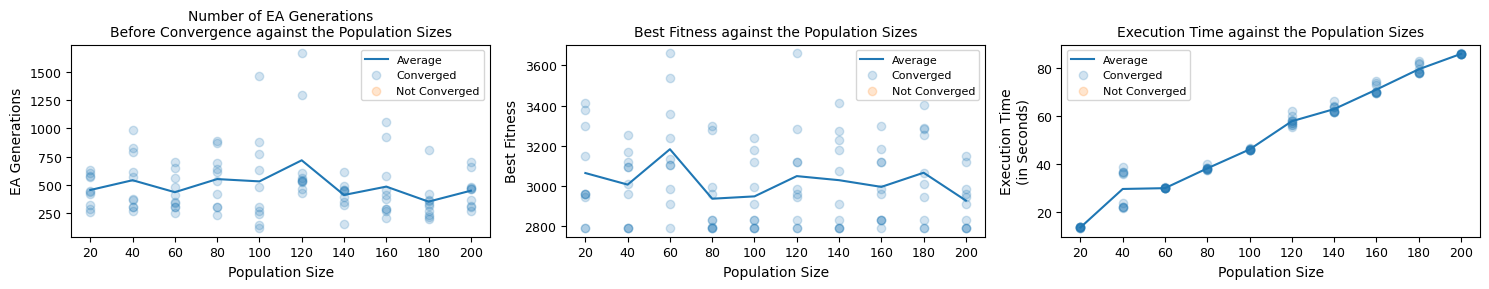

In [22]:
plot_results(burma_mean_conv_pop_exp, 
             burma_mean_best_fit_pop_exp, 
             burma_mean_elapsed_pop_exp, 
             burma_runs_pop_exp, 
             "p", 
             xticks=range(20, 220, 20), 
             ticksize=9,
             label_size=10,
             param_name="Population Size", 
             variable_type="continuous", 
             country="Burma")

In [23]:
burma_mean_best_fit_pop_exp.sort_values(by="run_best_fitness")

,run_params,run_best_fitness,p
6,"{'p': 200, 'tournament_size': 40, 'nb_mutation...",2925.9,200
9,"{'p': 80, 'tournament_size': 16, 'nb_mutations...",2935.1,80
0,"{'p': 100, 'tournament_size': 20, 'nb_mutation...",2946.8,100
3,"{'p': 160, 'tournament_size': 32, 'nb_mutation...",2994.1,160
7,"{'p': 40, 'tournament_size': 8, 'nb_mutations'...",3005.5,40
2,"{'p': 140, 'tournament_size': 28, 'nb_mutation...",3027.6,140
1,"{'p': 120, 'tournament_size': 24, 'nb_mutation...",3047.9,120
5,"{'p': 20, 'tournament_size': 4, 'nb_mutations'...",3063.2,20
4,"{'p': 180, 'tournament_size': 36, 'nb_mutation...",3064.8,180
8,"{'p': 60, 'tournament_size': 12, 'nb_mutations...",3182.1,60


Although 80 does not return the best average "run_best_fitness", it is the second best population size in terms of average best fitness, has a reasonable convergence rate and a much better execution time than the population size which has the best average "run_best_fitness" 80 is deemed to be the best population size. 

 <u> Experiment on the tournament size </u>
 
 Keep other parameters fixed whilst varying tournament size as a percentage of the best population size
 found previously. Run the Evolutionary Algorithm 10 times for each parameter set to get more accurate performance results as it is a random process.

In [24]:
# tournament_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# p_burma = 80
# for tournament_size in tournament_sizes:
#     for i in range(1, 11):
#         random.seed(i)
#         print(f"Tournament Size: {tournament_size}, Run: {i}")
#         TSP(burma_dist_mat, 
#             burma_city_ids, 
#             p = p_burma,
#             tournament_size = int(p_burma * tournament_size), 
#             nb_mutations=1,
#             replacement_type="worse", 
#             crossover_type="ordered", 
#             maxit = 10000, 
#             output_file="burma_tournament_size_experiment.csv"
#             )

- Read in the data from the experiment on tournament size for the Burma data
- Format it
- Plot it

In [25]:
burma_mean_conv_tourn_size_exp, burma_mean_best_fit_tourn_size_exp, burma_mean_elapsed_tourn_size_exp, burma_runs_tourn_size_exp = format_results("Data/burma_tournament_size_experiment.csv", "tournament_size")

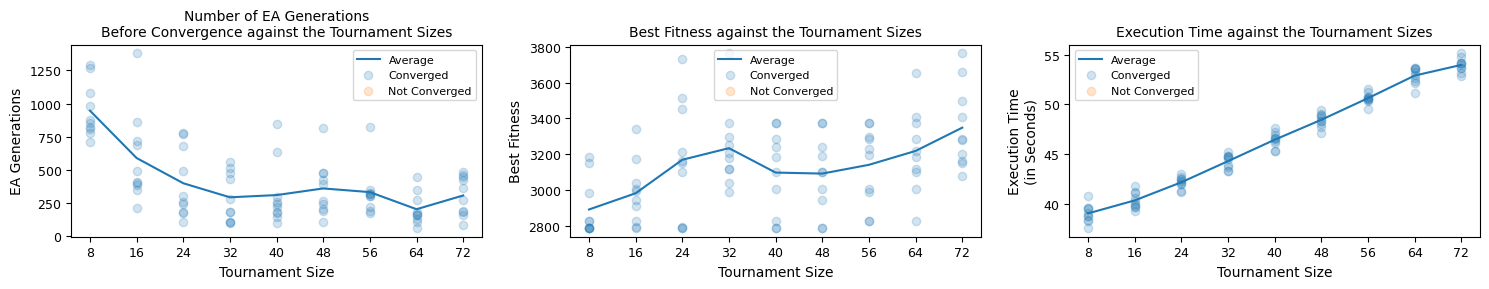

In [26]:
plot_results(burma_mean_conv_tourn_size_exp, 
             burma_mean_best_fit_tourn_size_exp, 
             burma_mean_elapsed_tourn_size_exp, 
             burma_runs_tourn_size_exp, 
             param="tournament_size", 
             xticks=np.arange(0.1, 1, 0.1)*80, 
             ticksize=9,
             label_size=10,
             param_name="Tournament Size", 
             variable_type="continuous", 
             country="Burma")

Although a tournament size of 8 takes considerably longer to converge than the other tournament sizes, it is still a reasonable amount of EA generations and performs the best in terms of average best fitness and execution time. Therefore, we will deem a tournament size of 8, or 10% of the population size, to be the best tournament size. 

<u> Experiment on the crossover type </u>
 
 Keep other parameters fixed whilst varying the crossover type (crossover with fix or ordered crossover). The population and tournament sizes are chosen to be the best values of each found in the previous experiments. Run the Evolutionary Algorithm 10 times for each parameter set to get more accurate performance results as it is a random process.

In [27]:
# crossover_types = ["fix", "ordered"]
# p_burma = 80
# tournament_size_burma = 8
# for crossover_type in crossover_types:
#     for i in range(1, 11):
#         random.seed(i)
#         print(f"Crossover Type: {crossover_type}, Run: {i}")
#         TSP(burma_dist_mat, 
#             burma_city_ids, 
#             p = p_burma, 
#             tournament_size = int(tournament_size_burma), 
#             nb_mutations=1,
#             replacement_type="worse", 
#             crossover_type=crossover_type, 
#             maxit = 10000, 
#             output_file="burma_crossover_type_experiment.csv"
#             )

- Read in the data from the experiment on crossover type for the Burma data
- Format it
- Plot it

In [28]:
burma_mean_conv_cross_type_exp, burma_mean_best_fit_cross_type_exp, burma_mean_elapsed_cross_type_exp, burma_runs_cross_type_exp = format_results("Data/burma_crossover_type_experiment.csv", "crossover_type")

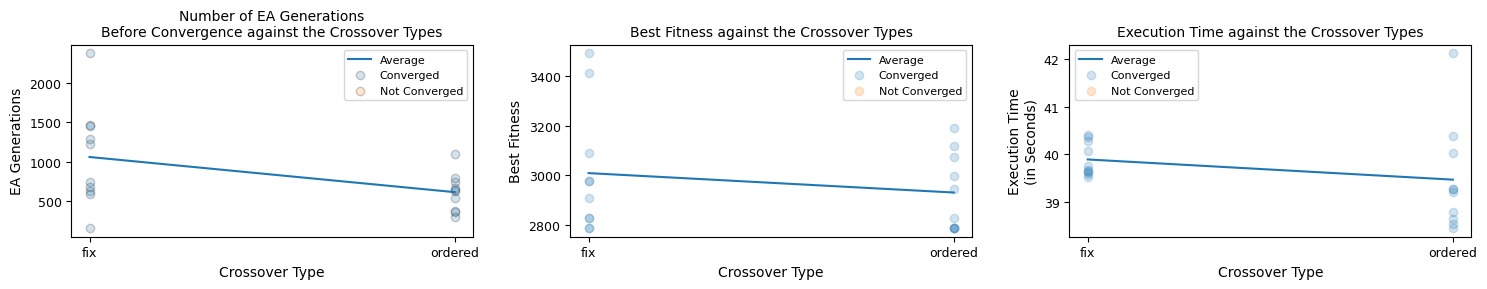

In [29]:
plot_results(burma_mean_conv_cross_type_exp, 
             burma_mean_best_fit_cross_type_exp, 
             burma_mean_elapsed_cross_type_exp, 
             burma_runs_cross_type_exp, 
             param="crossover_type", 
             xticks=None, 
             ticksize=9,
             label_size=10,
             param_name="Crossover Type", 
             variable_type="categorical", 
             country = "Burma")

Both crossover types perform the same across both the average best fitness and execution time. However, the runs where ordered crossover was performed yielded a better a convergence time and a slightly better averga fitness. Therefore, we deem ordered crossover to be the best performing crossover type.

 <u> Experiment on the type/number of mutation(s) </u>
 
 Keep other parameters fixed whilst varying the type/number of mutation(s) (inversion mutation or a number of swap mutations ranging from 1 to 7, which is half the amount of cities). The population and tournament sizes, and the crossover type are chosen to be the best values of each found in the previous experiments. Run the Evolutionary Algorithm 10 times for each parameter set to get more accurate performance results as it is a random process.

In [30]:
# mutations = [-1] + list(range(1, 8))
# p_burma = 80
# tournament_size_burma = 8
# crossover_type_burma = "ordered"
# for m in mutations:
#     for i in range(1, 11):
#         random.seed(i)
#         print(f"Mutations: {m}, Run: {i}")
#         TSP(burma_dist_mat, 
#             burma_city_ids, 
#             p = p_burma, 
#             tournament_size = int(tournament_size_burma), 
#             nb_mutations=m,
#             replacement_type="worse", 
#             crossover_type=crossover_type_burma,
#             maxit = 10000, 
#             output_file="burma_mutations_experiment.csv"
#             )

- Read in the data from the experiment on mutations for the Burma data
- Format it
- Plot it

In [31]:
burma_mean_conv_mut_exp, burma_mean_best_fit_mut_exp, burma_mean_elapsed_mut_exp, burma_runs_mut_exp = format_results("Data/burma_mutations_experiment.csv", "nb_mutations")

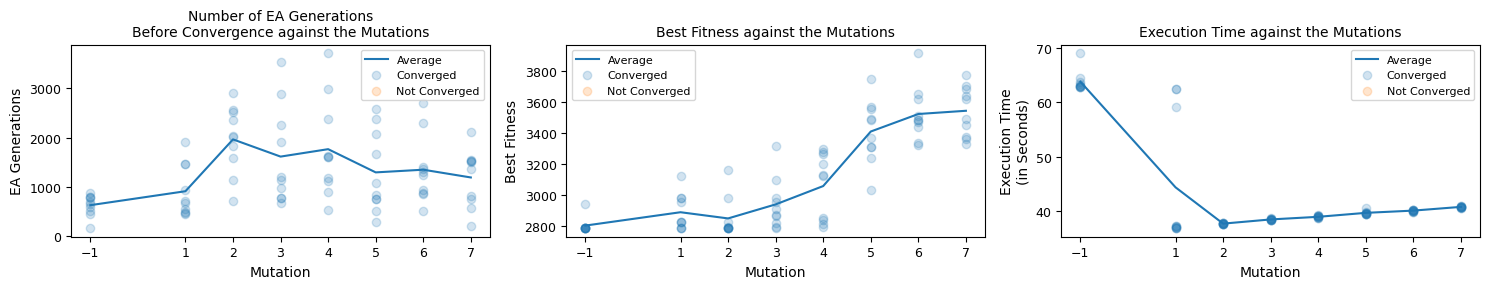

In [32]:
plot_results(burma_mean_conv_mut_exp, 
             burma_mean_best_fit_mut_exp, 
             burma_mean_elapsed_mut_exp, 
             burma_runs_mut_exp, 
             param="nb_mutations", 
             xticks=[-1, 1, 2, 3, 4, 5, 6, 7], 
             ticksize=9,
             label_size=10,
             param_name="Mutation", 
             variable_type="continuous", 
             country = "Burma")

Although yielding a much greater execution time than any number of swap mutations, the runs which used inversion mutation performed much better in terms of average convergence speed and average quality of solution and so inversion mutation is deemed to be the better mutation type.

<u> Experiment on the replacement type </u>
 
 Keep other parameters fixed whilst varying the replacement type (worse or first worse). The population and tournament sizes, the crossover type and mutations type are chosen to be the best values of each found in the previous experiments. Run the Evolutionary Algorithm 10 times for each parameter set to get more accurate performance results as it is a random process.

In [33]:
# p_burma = 80
# tournament_size_burma = 8
# crossover_type_burma = "ordered"
# mutations = -1
# replacement_types = ["worse", "first worse"]
# for rep_type in replacement_types:
#     for i in range(1, 11):
#         random.seed(i)
#         print(f"Mutations: {rep_type}, Run: {i}")
#         TSP(burma_dist_mat, 
#             burma_city_ids, 
#             p = p_burma, 
#             tournament_size = tournament_size_burma,
#             nb_mutations=mutations, 
#             replacement_type=rep_type, 
#             crossover_type=crossover_type_burma, 
#             maxit = 10000, 
#             output_file="burma_replacement_type_experiment.csv"
#             )

- Read in the data from the experiment on replacement type for the Burma data
- Format it
- Plot it

In [34]:
burma_mean_conv_replacement_exp, burma_mean_best_fit_replacement_exp, burma_mean_elapsed_replacement_exp, burma_runs_replacement_exp = format_results("Data/burma_replacement_type_experiment.csv", "replacement_type")

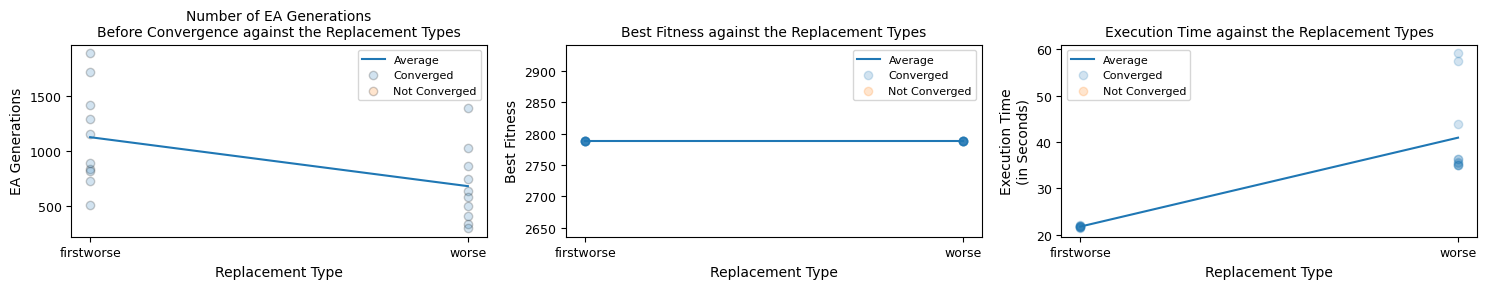

In [35]:
plot_results(burma_mean_conv_replacement_exp, 
             burma_mean_best_fit_replacement_exp, 
             burma_mean_elapsed_replacement_exp, 
             burma_runs_replacement_exp,
             param="replacement_type", 
             xticks=None, 
             ticksize=9,
             label_size=10,
             param_name="Replacement Type", 
             variable_type="categorical", 
             country= "Burma")

Both first worse replacement and worse replacement performed the same in terms of the average across all runs of the fitness of the best solution found at the end of the algorithm. However, worse replacement performed better in terms of convergence speed and first worse replacement performed better in terms of execution time. Due to its better convergence speed, worse replacement is deemed to be the best replacement type.

Display the best solutions and the amount of times they were achieved by the runs. 

In [36]:
all_burma_runs = pd.concat([burma_runs_pop_exp, burma_runs_tourn_size_exp, burma_runs_cross_type_exp, burma_runs_mut_exp, burma_runs_replacement_exp])
merged = all_burma_runs.value_counts("run_best_solution").reset_index().merge(all_burma_runs[["run_best_solution", "run_best_fitness"]], how = "inner", on = "run_best_solution")
merged = merged.drop_duplicates().sort_values("run_best_fitness").head(10).rename(columns={"run_best_solution": "solution",
                                                                                  "run_best_fitness": "fitness",
                                                                                  0: "nb_of_runs_found_by"})
merged

,solution,nb_of_runs_found_by,fitness
0,"[13, 2, 3, 4, 5, 11, 6, 12, 1, 0, 7, 10, 8, 9]",80,2789.0
156,"[13, 2, 3, 4, 5, 11, 6, 12, 7, 1, 0, 10, 8, 9]",6,2796.0
297,"[13, 2, 3, 4, 11, 5, 6, 12, 1, 0, 7, 10, 8, 9]",1,2812.0
289,"[13, 2, 3, 4, 5, 11, 6, 12, 7, 0, 1, 10, 8, 9]",1,2822.0
80,"[13, 12, 6, 11, 5, 4, 3, 2, 1, 0, 7, 10, 8, 9]",25,2830.0
292,"[13, 2, 3, 4, 5, 11, 6, 12, 0, 1, 7, 10, 8, 9]",1,2841.0
291,"[13, 2, 3, 4, 5, 11, 6, 12, 1, 0, 7, 8, 10, 9]",1,2852.0
261,"[13, 2, 3, 4, 11, 5, 6, 12, 7, 1, 0, 8, 10, 9]",1,2864.0
296,"[13, 2, 3, 4, 11, 5, 6, 12, 1, 0, 7, 8, 10, 9]",1,2875.0
143,"[13, 2, 3, 4, 5, 11, 6, 12, 10, 8, 7, 0, 1, 9]",7,2911.0


In [37]:
# merged.to_csv("10_best_burma_solutions.csv")

### Brazil Experiments

<u> Experiment on the population size </u>
 
 Keep other parameters fixed whilst varying population size in increments of 20 from 60 to 300. Run the Evolutionary Algorithm 10 times for each parameter set to get more accurate performance results as it is a random process.

In [38]:
# pop_sizes = range(60, 320, 20)
# for pop_size in pop_sizes:
#     for i in range(1, 11):
#         random.seed(i)
#         print(f"Population Size: {pop_size}, Run: {i}")
#         TSP(braz_dist_mat, 
#             brazil_city_ids, 
#             p = pop_size, 
#             tournament_size = int(pop_size * 0.2), 
#             nb_mutations=1,
#             replacement_type="worse", 
#             crossover_type="ordered", 
#             maxit = 10000, 
#             output_file="brazil_pop_size_experiment.csv"
#             )

- Read in the data from the experiment on population size for the Brazil data
- Format it
- Plot it

In [39]:
brazil_mean_conv_pop_size_exp, brazil_mean_best_fit_pop_size_exp, brazil_mean_elapsed_pop_size_exp, brazil_runs_pop_size_exp = format_results("Data/brazil_pop_size_experiment.csv", "p")

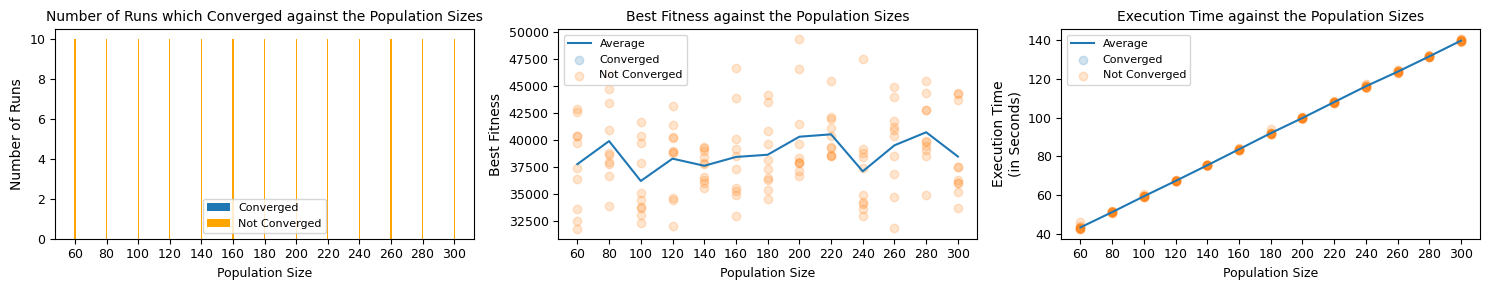

In [40]:
plot_results(brazil_mean_conv_pop_size_exp, 
             brazil_mean_best_fit_pop_size_exp, 
             brazil_mean_elapsed_pop_size_exp, 
             brazil_runs_pop_size_exp, 
             "p", 
             xticks=range(60, 320, 20), 
             ticksize=9,
             label_size=9,
             param_name="Population Size", 
             variable_type="continuous", 
             country="Brazil")

As we can see from the plot, none of the runs converge. This is expected due to the size of the number of cities in the Brazil file compared to Burma. Therefore, a population size of 100 is deemed to be the best performing population size as it yields the best average fitness and a reasonable execution time. 

 <u> Experiment on the tournament size </u>
 
 Keep other parameters fixed whilst varying tournament size as a percentage of the best population size
 found previously. Run the Evolutionary Algorithm 10 times for each parameter set to get more accurate performance results as it is a random process.

In [41]:
# tournament_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# p_brazil = 100 
# for tournament_size in tournament_sizes:
#     for i in range(1, 11):
#         random.seed(i)
#         print(f"Tournament Size: {tournament_size * p}, Run: {i}")
#         TSP(braz_dist_mat, 
#             brazil_city_ids, 
#             p = p_brazil, 
#             tournament_size = int(p_brazil * tournament_size), 
#             nb_mutations=1,
#             replacement_type="worse", 
#             crossover_type="ordered", 
#             maxit = 10000, 
#             output_file="brazil_tournament_size_experiment.csv"
#             )

- Read in the data from the experiment on tournament size for the Brazil data
- Format it
- Plot it

In [42]:
brazil_mean_conv_tourn_size_exp, brazil_mean_best_fit_tourn_size_exp, brazil_mean_elapsed_tourn_size_exp, brazil_runs_tourn_size_exp = format_results("Data/brazil_tournament_size_experiment.csv", "tournament_size")

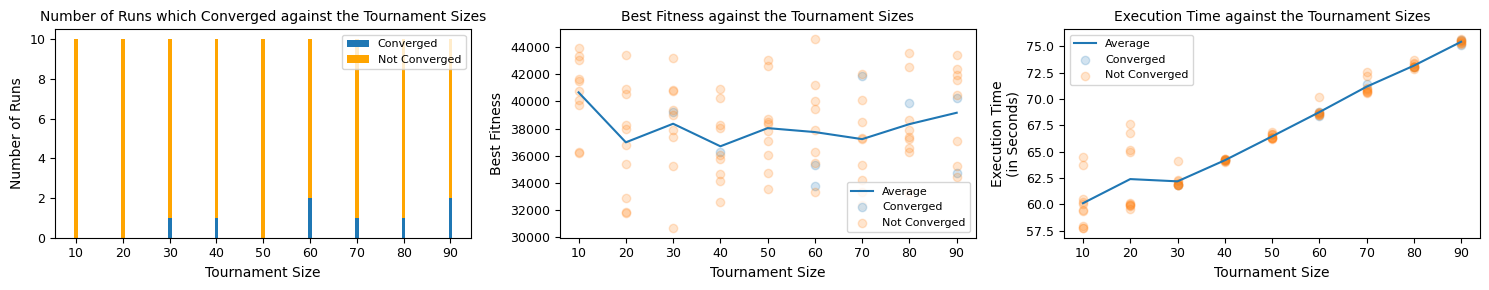

In [43]:
plot_results(brazil_mean_conv_tourn_size_exp, 
             brazil_mean_best_fit_tourn_size_exp, 
             brazil_mean_elapsed_tourn_size_exp, 
             brazil_runs_tourn_size_exp,
             param="tournament_size", 
             xticks=np.arange(0.1, 1, 0.1)*100, 
             ticksize=9,
             label_size=10,
             param_name="Tournament Size", 
             variable_type="continuous", 
             country="Brazil")

Once again, a low amount of runs converge due to the high number of Brazil cities compared to Burma cities. We deem 40 to be the best tournament size as it has a reasonable average execution time and yields the best average quality of solution.

<u> Experiment on the crossover type </u>
 
 Keep other parameters fixed whilst varying the crossover type (crossover with fix or ordered crossover). The population and tournament sizes are chosen to be the best values of each found in the previous experiments. Run the Evolutionary Algorithm 10 times for each parameter set to get more accurate performance results as it is a random process.

Experiment on crossover type

In [44]:
# crossover_types = ["fix", "ordered"]
# p_brazil = 100
# tournament_size_brazil = 40
# for crossover_type in crossover_types:
#     for i in range(1, 11):
#         random.seed(i)
#         print(f"Crossover Type: {crossover_type}, Run: {i}")
#         TSP(braz_dist_mat, 
#             brazil_city_ids, 
#             p = p_brazil, 
#             tournament_size = tournament_size_brazil, 
#             nb_mutations=1,
#             replacement_type="worse", 
#             crossover_type=crossover_type, 
#             maxit = 10000, 
#             output_file="brazil_crossover_type_experiment.csv"
#             )

- Read in the data from the experiment on crossover type for the Brazil data
- Format it
- Plot it

In [45]:
brazil_mean_conv_cross_type_exp, brazil_mean_best_fit_cross_type_exp, brazil_mean_elapsed_cross_type_exp, brazil_runs_cross_type_exp = format_results("Data/brazil_crossover_type_experiment.csv", "crossover_type")

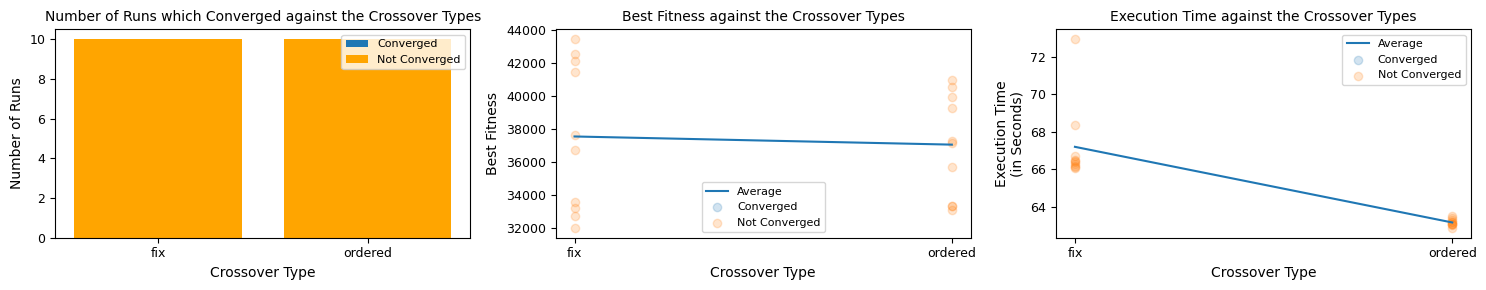

In [46]:
plot_results(brazil_mean_conv_cross_type_exp, 
             brazil_mean_best_fit_cross_type_exp, 
             brazil_mean_elapsed_cross_type_exp, 
             brazil_runs_cross_type_exp,
             param="crossover_type", 
             xticks=np.arange(0.1, 1, 0.1)*100, 
             ticksize=9,
             label_size=10,
             param_name="Crossover Type", 
             variable_type="categorical", 
             country="Brazil")

For both crossover types, none of the runs convergence and they have a similar average run best fitness, with ordered crossover being slighlty better. On the other hand, ordered crossover yields a lower execution time than fixed crossover, therefore ordered crossover was deemed to be the best crossover type.

 <u> Experiment on the type/number of mutation(s) </u>
 
 Keep other parameters fixed whilst varying the type/number of mutation(s) (inversion mutation or a number of swap mutations ranging from 1 to 26, which is around half the amount of cities). The population and tournament sizes, and the crossover type are chosen to be the best values of each found in the previous experiments. Run the Evolutionary Algorithm 10 times for each parameter set to get more accurate performance results as it is a random process.

In [47]:
# mutations = [-1] + list(range(1, 27))
# p_brazil = 100 # best value of p found in previous experiment considering best average fitness and execution time tradeoff
# tournament_size_brazil = 40 # best tournament size found previously
# cross_type_brazil = "ordered"
# for m in mutations:
#     for i in range(1, 11):
#         random.seed(i)
#         print(f"Mutations: {m}, Run: {i}")
#         TSP(braz_dist_mat, 
#             brazil_city_ids, 
#             p = p_brazil, 
#             tournament_size = int(tournament_size_brazil), 
#             nb_mutations=m,
#             replacement_type="worse", 
#             crossover_type= cross_type_brazil, 
#             maxit = 10000, 
#             output_file="brazil_mutations_experiment.csv"
#             )

- Read in the data from the experiment on mutations for the Brazil data
- Format it
- Plot it

In [48]:
brazil_mean_conv_mutation_exp, brazil_mean_best_fit_mutation_exp, brazil_mean_elapsed_mutation_exp, brazil_runs_mutation_exp = format_results("Data/brazil_mutations_experiment.csv", "nb_mutations")

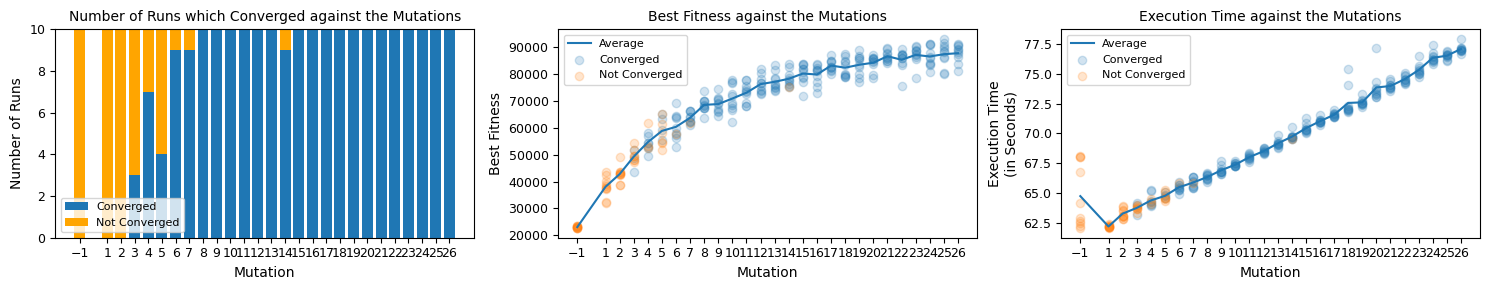

In [49]:
plot_results(brazil_mean_conv_mutation_exp, 
             brazil_mean_best_fit_mutation_exp, 
             brazil_mean_elapsed_mutation_exp,
             brazil_runs_mutation_exp,
             param="nb_mutations", 
             xticks=[-1] + list(range(1, 27)), 
             ticksize=9,
             label_size=10,
             param_name="Mutation", 
             variable_type="continuous", 
             country="Brazil")

From the plots, we can see that as the number of mutations increase, the amount of runs which converge also increases. However, as shown by the average best fitness plot, they converge towards suboptimal solutions and see an increase in execution time. On the other hand, using inversion mutation leads to no runs converging, however, the average best fitness for the runs which used inversion mutation is much better than all the runs in which swap mutation was used. Therefore, inversion mutation was deemed to be the best mutation type. 

<u> Experiment on the replacement type </u>
 
 Keep other parameters fixed whilst varying the replacement type (worse or first worse). The population and tournament sizes, the crossover type and mutations type are chosen to be the best values of each found in the previous experiments. Run the Evolutionary Algorithm 10 times for each parameter set to get more accurate performance results as it is a random process.

In [50]:
# replacement_types = ["worse", "first worse"]
# p_brazil = 100 # best value of p found in previous experiment considering best average fitness and execution time tradeoff
# tournament_size_brazil = 40 # best tournament size found previously
# cross_type_brazil = "ordered"
# mutations_brazil = -1
# for replacement_type in replacement_types:
#     for i in range(1, 11):
#         random.seed(i)
#         print(f"Replacement Type: {replacement_type}, Run: {i}")
#         TSP(braz_dist_mat, 
#             brazil_city_ids, 
#             p = p_brazil, 
#             tournament_size = int(tournament_size_brazil), 
#             nb_mutations=mutations_brazil,
#             replacement_type=replacement_type, 
#             crossover_type= cross_type_brazil, 
#             maxit = 10000, 
#             output_file="brazil_replacement_type_experiment.csv"
#             )
        

In [51]:
brazil_mean_conv_replacement_type_exp, brazil_mean_best_fit_replacement_type_exp, brazil_mean_elapsed_replacement_type_exp, brazil_runs_replacement_type_exp = format_results("Data/brazil_replacement_type_experiment.csv", "replacement_type")

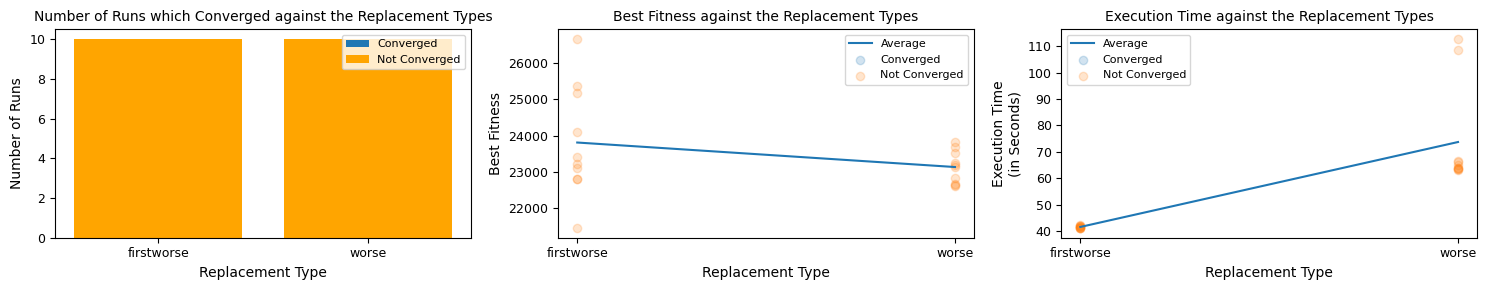

In [52]:
plot_results(brazil_mean_conv_replacement_type_exp, 
             brazil_mean_best_fit_replacement_type_exp, 
             brazil_mean_elapsed_replacement_type_exp, 
             brazil_runs_replacement_type_exp,
             param="replacement_type", 
             xticks=None, 
             ticksize=9,
             label_size=10,
             param_name="Replacement Type", 
             variable_type="categorical", 
             country="Brazil")

Although using worse replacement leads to a greater execution time than using first worse replacement, using worse replacement, we obtain a slightly better average quality of solution compared to first worse deplacement. Therefore, we can deem that worse replacement is the better replacement type. 

Display the best solutions and the amount of times they were achieved by the runs. 

In [53]:
all_brazil_runs = pd.concat([brazil_runs_pop_size_exp, brazil_runs_tourn_size_exp, brazil_runs_cross_type_exp, brazil_runs_mutation_exp, brazil_runs_replacement_type_exp])
merged = all_brazil_runs.value_counts("run_best_solution").reset_index().merge(all_brazil_runs[["run_best_solution", "run_best_fitness"]], how = "inner", on = "run_best_solution")
merged = merged.drop_duplicates().sort_values("run_best_fitness").head(10).rename(columns={"run_best_solution": "solution",
                                                                                  "run_best_fitness": "fitness",
                                                                                  0: "nb_of_runs_found_by"})
merged

,solution,nb_of_runs_found_by,fitness
220,"[57, 23, 43, 17, 0, 29, 12, 39, 24, 8, 31, 19,...",1,21445.0
151,"[57, 52, 49, 3, 19, 31, 39, 24, 8, 12, 29, 0, ...",1,22611.0
212,"[57, 23, 56, 11, 26, 42, 48, 51, 50, 46, 35, 1...",1,22631.0
217,"[57, 23, 43, 17, 0, 29, 39, 12, 24, 8, 31, 19,...",1,22652.0
257,"[57, 4, 22, 26, 42, 11, 56, 23, 43, 17, 0, 29,...",1,22656.0
134,"[57, 52, 49, 3, 19, 31, 8, 24, 39, 12, 29, 0, ...",1,22731.0
39,"[57, 17, 3, 49, 52, 19, 31, 12, 24, 8, 39, 29,...",1,22805.0
153,"[57, 52, 3, 49, 19, 31, 8, 24, 39, 12, 29, 0, ...",1,22810.0
248,"[57, 4, 54, 53, 1, 40, 47, 28, 32, 44, 55, 45,...",1,22844.0
210,"[57, 23, 56, 11, 42, 48, 46, 50, 26, 4, 22, 43...",1,22892.0


In [54]:
# merged.to_csv("10_best_brazil_solutions.csv")